In [1]:
import numpy as np
import gym
import matplotlib.pyplot as plt
import gc
import random
import time

from collections import deque,namedtuple
from IPython.display import clear_output

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import models

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import copy

In [2]:
env = gym.make('MountainCar-v0')#import of our environment

states = env.observation_space.shape[0]
actions = env.action_space.n

In [3]:
actions#number of actions


3

In [4]:
states# number of states

2

# Test our env with random actions

In [31]:
episodes = 10
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0 
    
    while not done:
        env.render()
        action = random.choice([0,1])
        n_state, reward, done, info = env.step(action)
        score+=reward
    print('Episode:{} Score:{}'.format(episode, score))
    
env.close()

Episode:1 Score:-200.0
Episode:2 Score:-200.0
Episode:3 Score:-200.0
Episode:4 Score:-200.0
Episode:5 Score:-200.0
Episode:6 Score:-200.0
Episode:7 Score:-200.0
Episode:8 Score:-200.0
Episode:9 Score:-200.0
Episode:10 Score:-200.0


# Create a Deep Learning Model

# DQN

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

n_actions = env.action_space.n
n_states = env.observation_space.shape[0]

In [6]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

In [7]:
class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [8]:
class DQN:
    def __init__(self, layers, lr=0.0005, optim_method=optim.Adam):
        self.layers = layers
        self.lr = lr
        self.loss = F.mse_loss
        self.optim_method = optim_method
        self.TargetNetwork = None
        self.EstimateNetwork = None
        self.optimizer = None
        self.build_model()

    def build_model(self):
        def init_weights(layer):
            if type(layer) == nn.Linear:
                nn.init.xavier_normal_(layer.weight)

        self.EstimateNetwork = nn.Sequential(*self.layers)
        self.EstimateNetwork.apply(init_weights)

        layers_for_target = copy.deepcopy(self.layers)
        self.TargetNetwork = nn.Sequential(*layers_for_target)
        self.TargetNetwork.load_state_dict(self.EstimateNetwork.state_dict())

        self.optimizer = self.optim_method(self.EstimateNetwork.parameters(), lr=self.lr)

    def Q_target(self, inp):
        return self.TargetNetwork(inp)

    def Q_estimate(self, inp):
        return self.EstimateNetwork(inp)

    def update_target(self):
        self.TargetNetwork.load_state_dict(self.EstimateNetwork.state_dict())

    def update_parameters(self, estimated, targets):
        loss = self.loss(estimated, targets.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()

        for param in self.EstimateNetwork.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

    def save(self, name):
        torch.save(self.EstimateNetwork, name)
        print('------ Model saved ------')

In [9]:
class Agent:
    def __init__(self, env, Model, n_actions, goal, min_score, \
                 eps_start=1, eps_end=0.001, eps_decay=0.9, gamma=0.99, \
                 batch_size=64, memory_size=100000, max_episode=2000, upd_rate=1):
        self.env = env 
        self.n_actions = n_actions # number of possible actions
        self.goal = goal # the score to reach during learning
        self.min_score = min_score # min score to complete the episode
        self.eps_start = eps_start 
        self.eps = eps_start
        self.eps_end = eps_end
        self.eps_decay = eps_decay
        self.gamma = gamma
        self.batch_size = batch_size
        self.target_update_rate = upd_rate # how often we update our target network
        self.Model = Model # DQN instance
        self.max_episode = max_episode # how long we train our agent
        self.memory = ReplayMemory(memory_size) # Replay buffer

    def act(self, state, eps): # epsilon greedy policy
        if random.random() < eps:
            return torch.tensor([[random.randrange(self.n_actions)]], device=device, dtype=torch.long)
        else:
            with torch.no_grad():
                result = self.Model.Q_estimate(state).max(1)[1]
                return result.view(1, 1)

    def optimize(self): # experience replay 
        if len(self.memory) < self.batch_size:
            return

        transitions = self.memory.sample(self.batch_size)
        batch = Transition(*zip(*transitions))

        next_state_batch = torch.cat(batch.next_state)
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        done_batch = torch.cat(batch.done)

        estimate_value = self.Model.Q_estimate(state_batch).gather(1, action_batch)

        Q_value_next = torch.zeros(self.batch_size, device=device)
        with torch.no_grad():
            Q_value_next[~done_batch] = self.Model.Q_target(next_state_batch).max(1)[0].detach()[~done_batch]
        target_value = (Q_value_next * self.gamma) + reward_batch

        self.Model.update_parameters(estimate_value, target_value)

    def train(self): # learning procedure 
        all_scores = []
        successful_sequences = 0
        for ep in range(1, self.max_episode + 1):
            state = self.env.reset()
            state = torch.tensor(state).to(device).float().unsqueeze(0)
            done = False
            episode_reward = 0

            while not done:
                action = self.act(state, self.eps) 
                action = torch.tensor(action).to(device)

                next_state, reward, done, info = self.env.step(action.item())
                episode_reward += reward

                modified_reward = reward + 300 * (self.gamma * abs(next_state[1]) - abs(state[0][1]))

                next_state = torch.tensor(next_state).to(device).float().unsqueeze(0)
                modified_reward = torch.tensor(modified_reward).to(device).float().unsqueeze(0)
                done = torch.tensor(done).to(device).unsqueeze(0)

                self.memory.push(state, action, next_state, modified_reward, done)
                state = next_state

                self.optimize() # experience replay

            
            if ep % self.target_update_rate == 0: 
                self.Model.update_target()

            self.eps = max(self.eps_end, self.eps * self.eps_decay)
            all_scores.append(episode_reward)

            if ep % 100 == 0:
                print('episode', ep, ':', np.mean(all_scores[:-100:-1]), 'average score')

            if np.mean(all_scores[:-100:-1]) >= self.goal:
                successful_sequences += 1
                if successful_sequences == 5:
                    print('success at episode', ep)
                    return all_scores
            else:
                successful_sequences = 0

        return all_scores

    def test(self, episodes=50, render=False): #test trained agent
        state = self.env.reset()
        state = torch.tensor(state).to(device).float().unsqueeze(0)
        ep_count = 0
        current_episode_reward = 0
        scores = []
        while ep_count < episodes:
            if render:
                env.render()
            action = self.act(state, 0)
            state, reward, done, _ = self.env.step(action.item())
            state = torch.tensor(state).to(device).float().unsqueeze(0)
            current_episode_reward += reward

            if done:
                ep_count += 1
                scores.append(current_episode_reward)
                current_episode_reward = 0
                state = self.env.reset()
                state = torch.tensor(state).to(device).float().unsqueeze(0)

        print('average score:', sum(scores) / len(scores))
        print('max reward:', max(scores))
        print('-----')
        print()

    def save(self, name='agent.pkl'): # save policy network
        self.Model.save(name)

In [10]:
layers = (
        nn.Linear(n_states, 256),
        nn.ReLU(),
        nn.Linear(256, 256),
        nn.ReLU(),
        nn.Linear(256, n_actions),
)

In [11]:
Model = DQN(layers, lr=0.0001, optim_method=optim.Adam)
MountainCarAgent = Agent(env, Model, n_actions, goal=-110, min_score=-200, \
                         eps_start=1, eps_end=0.001, eps_decay=0.9, gamma=0.99, \
                         batch_size=64, memory_size=100000, max_episode=2000)
scores = MountainCarAgent.train()

<ipython-input-9-452cf482a042>:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  action = torch.tensor(action).to(device)
<ipython-input-9-452cf482a042>:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  modified_reward = torch.tensor(modified_reward).to(device).float().unsqueeze(0)


episode 100 : -192.65656565656565 average score
episode 200 : -199.46464646464648 average score
episode 300 : -192.3838383838384 average score
episode 400 : -168.3030303030303 average score
episode 500 : -147.35353535353536 average score
episode 600 : -136.86868686868686 average score
episode 700 : -129.53535353535352 average score
episode 800 : -127.73737373737374 average score
episode 900 : -125.52525252525253 average score
episode 1000 : -123.78787878787878 average score
episode 1100 : -124.44444444444444 average score
episode 1200 : -113.76767676767676 average score
episode 1300 : -110.66666666666667 average score
success at episode 1309


In [ ]:
MountainCarAgent.test(episodes=100)

In [14]:
for i in range(5):
    state = env.reset()
    while True:   
        state = torch.tensor(state).to(device).float().unsqueeze(0)
        result = Model.Q_estimate(state).max(1)[1]
        action =result.view(1, 1)
        action = torch.tensor(action).to(device)
        
       
        state, reward, done, info = MountainCarAgent.env.step(action.item())

        env.render()
       
        if done:
            time.sleep(0.5)
            break
           
env.close()

<ipython-input-14-d54ca5eaf203>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  action = torch.tensor(action).to(device)


# Double DQN (from scratch)

In [5]:
def create_model(seed = 666):
    init = he_normal(seed = seed)#initializer that draws samples from a truncated normal distribution centered on 0 
    
    model = Sequential()
    model.add(Dense(64, input_shape = (2,), activation = 'relu', kernel_initializer = init))
    model.add(Dense(128, activation = 'relu', kernel_initializer = init))
    model.add(Dense(env.action_space.n, kernel_initializer = init))
    
    optimizer = SGD(learning_rate=1e-3)# here we used the SGD as an optimizer
    model.compile(optimizer = optimizer, loss = 'mse')#mean squared error as the loss function
    
    return model

### Initialize Hyperparams and variables

In [6]:
capacity = 5000 # Memory capacity
memory = deque(maxlen = capacity) # Defining memory
gamma = 0.99 # Discount rate for future reward

# Exploration rate
exploration_rate = 1 # Starting exploration rate
min_exploration_rate = 0.01 # Minimum exploration rate
max_exploration_rate = 1 # Maximum exploration rate
exploration_decay_rate = 0.001

episodes_to_play = 15 # Number of full episodes to play
batch_size = 32
update_counter = 0

#For future visualisation
positions = []
rewards = []
exploration_rates = []
losses = []
val_losses = []

# Defining policy and target nets
policy_net = create_model()
target_net = create_model()
target_net.set_weights(policy_net.get_weights())

### DDQN algorithme

Episode: 2


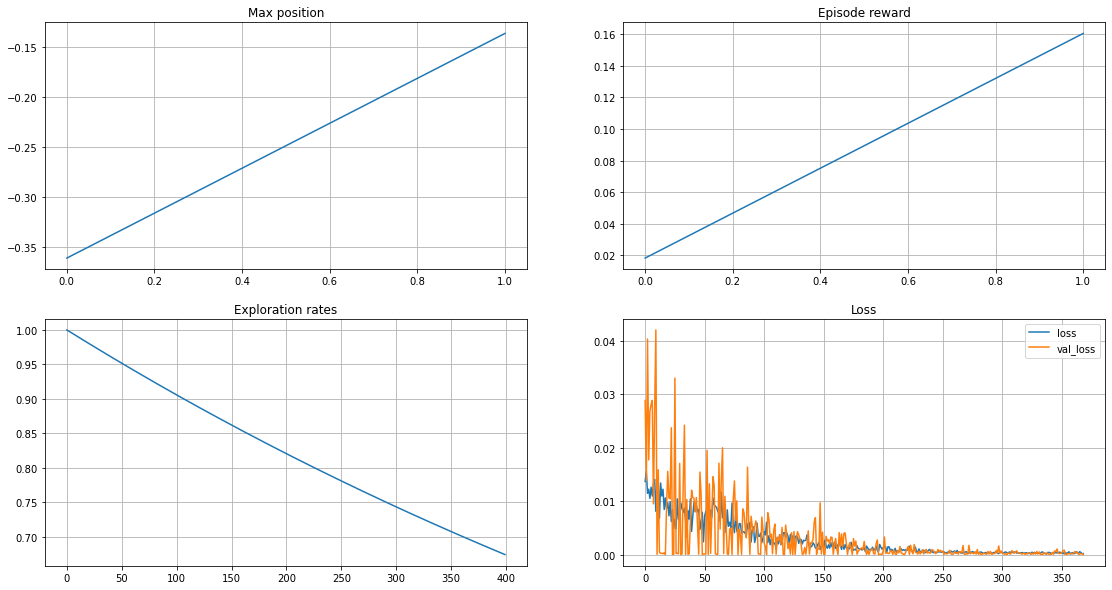

starting episode  2


In [ ]:
# Playing episodes
for episode in range(episodes_to_play):  
    print("starting episode ", episode)
    max_position = -1.2 # Track maximum position reached
    episode_reward = 0 # Track episode reward
    updated = False # Whether target net updated in this episode or not
    
    state = env.reset() # Get initial state
    
    # Play until episode is done
    while True:
        # Tune exploration rate
        exploration_rate = min_exploration_rate + (max_exploration_rate - min_exploration_rate) * np.exp(- exploration_decay_rate * (update_counter))
        
        # Store exploration rate in list for future visualization
        exploration_rates.append(exploration_rate)
        
        # Chosing an action according to the e-greedy strategy
        exploration_rate_thresh = random.uniform(0, 1)        
        if exploration_rate_thresh < exploration_rate:
            action = env.action_space.sample()
        else:
            action = policy_net.predict(state.reshape((-1, 2)))
            action = np.argmax(action[0])
        
        # Executing the action
        new_state, reward, done, info = env.step(action)
        
        # Modifying reward. If a cart reaches 0.5 distance or higher - it gets additional reward
        reward = 100*((np.sin(3 * new_state[0]) * 0.0025 + 0.5 * new_state[1] * new_state[1]) - (np.sin(3 * state[0]) * 0.0025 + 0.5 * state[1] * state[1])) 
        if new_state[0] >= 0.5:
            reward += 1
        
        episode_reward += reward
        
        # Storing observation in memory
        memory.append([state, action, reward, new_state, done])
        
        # Tracking maximum reached distance
        if new_state[0] > max_position:
            max_position = new_state[0]
        
        # Policy net training
        if len(memory) >= batch_size:
            # Taking random sample of observations from memory
            observations = random.sample(memory, batch_size)
            targets = []
            
            # Loop through all observation in the sample
            for obs in observations:
                state_, action_, reward_, new_state_, done_ = obs
                
                # Predict target using policy_net
                target = policy_net.predict(state_.reshape((-1, 2)))
                
                # Updating Q-values
                if done_:
                    target[0, action_] = reward_
                else:
                    Q_optimal = max(target_net.predict(new_state_.reshape((-1, 2)))[0])
                    target[0, action_] = reward_ + Q_optimal * gamma
                targets.append(target[0])
            
            # Preparing data for policy_net training
            observations = np.array([obs[0] for obs in observations], dtype = 'float32')
            targets = np.array(targets)
            
            # Training policy_net
            h = policy_net.fit(observations, targets, epochs = 1, verbose = 0, validation_split = 0.1)
            
            # Store losses for visualization purposes
            losses.append(h.history['loss'][0])
            val_losses.append(h.history['val_loss'][0])
        
        # Update target_net weights each 5 full episodes
        if (episode+1)%5 == 0 and not updated:
            print('Updating target_net weights')
            target_net.set_weights(policy_net.get_weights())
            updated = True
        
        update_counter += 1
        
        state = new_state
        
        if done:
            break
    print("episode ",episode, "----score:",episode_reward)
    # Store episode max position and reward for future visualization
    positions.append(max_position)
    rewards.append(episode_reward)
    
    # Plots
    clear_output(wait = True)
    print(f'Episode: {episode+1}')
    plt.figure(figsize = (19, 10))
    
    # Episode max position plot
    plt.subplot(221)
    plt.plot(range(len(positions)), positions)
    plt.grid(); plt.title('Max position')
    
    # Episode reward plot
    plt.subplot(222)
    plt.plot(range(len(positions)), rewards)
    plt.grid(); plt.title('Episode reward') 
    
    # Esploration rate for each frame
    plt.subplot(223)
    plt.plot(range(len(exploration_rates)), exploration_rates)
    plt.grid(); plt.title('Exploration rates')
    
    # Loss plot
    plt.subplot(224)
    plt.plot(range(len(losses)), losses, label = 'loss')
    plt.plot(range(len(losses)), val_losses, label = 'val_loss')
    plt.grid(); plt.legend(), plt.title('Loss')
    plt.show()
    
    gc.collect()

### Save the model

In [8]:
policy_net.save('./trained_network.h5')

### Load and Test the model

In [11]:
model=models.load_model('trained_network.h5')

In [12]:
for i in range(5):
    state = env.reset()
    
    while True:        
        action = model.predict(state.reshape((-1, 2)))
        action = np.argmax(action[0])
       
        state, reward, done, info = env.step(action)
       
        env.render()
       
        if done:
            time.sleep(0.5)
            break
           
env.close()

In [ ]:
MountainCarAgent.test(episodes=100)